In [1]:
import pandas as pd
import mysql.connector
import os

# Single CSV file and its corresponding table name
csv_file = 'Methane_final.csv'
table_name = 'project1'

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Harshk@22',
    database='project1'
)
cursor = conn.cursor()

# Folder containing the CSV file
folder_path = 'C:/Users/harshwardhan/Downloads'
file_path = os.path.join(folder_path, csv_file)

# Function to map pandas data types to SQL types
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Process the single CSV file
if os.path.exists(file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()
    print(f"Successfully processed: {csv_file}")
else:
    print(f"File not found: {file_path}")

# Close the connection
conn.close()

Processing Methane_final.csv
NaN values before replacement:
Unnamed: 0    0
region        0
country       0
emissions     0
type          0
segment       0
reason        0
baseYear      0
notes         0
dtype: int64

Successfully processed: Methane_final.csv


In [2]:
# CONNECTION WITH MYSQL WORKBENCH WITH JUPYTER

In [3]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect( host = "localhost",
                             username = "root",
                             password = "Harshk@22",
                             database = "project1"
                            )
cur = db.cursor()

In [4]:
import pandas as pd

# Load the dataset
file_path = 'Methane_final.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Verify that the data is a DataFrame
print(type(data))  # This should output <class 'pandas.core.frame.DataFrame'>
print(data.head())  # Check the first few rows to verify the content

<class 'pandas.core.frame.DataFrame'>
   Unnamed: 0  region  country   emissions         type  \
0           0  Africa  Algeria  257.611206  Agriculture   
1           1  Africa  Algeria    0.052000       Energy   
2           2  Africa  Algeria  130.798996       Energy   
3           3  Africa  Algeria   69.741898       Energy   
4           4  Africa  Algeria  213.987000       Energy   

                            segment    reason   baseYear  \
0                             Total       All  2019-2021   
1                         Bioenergy       All       2022   
2  Gas pipelines and LNG facilities  Fugitive       2022   
3  Gas pipelines and LNG facilities    Vented       2022   
4                       Onshore gas  Fugitive       2022   

                                               notes  
0  Average based on United Nations Framework Conv...  
1  Estimates from end-uses are for 2020 or 2021 (...  
2                                      Not available  
3                         

# 1) What is the total emissions by region

In [5]:
query="""SELECT region, SUM(emissions) AS total_emissions
FROM project1
GROUP BY region
ORDER BY total_emissions DESC;"""
cur.execute(query)

data = cur.fetchall()

data

[('World', 9293894.022155762),
 ('Asia Pacific', 3376292.6178353997),
 ('North America', 1203600.7743717358),
 ('Russia & Caspian', 1186010.634847479),
 ('Africa', 1029745.8996496501),
 ('Europe', 934970.9395401462),
 ('Central and South America', 867159.8061868013),
 ('Middle East', 723820.1765003875),
 ('Other', 303949.7863308761)]

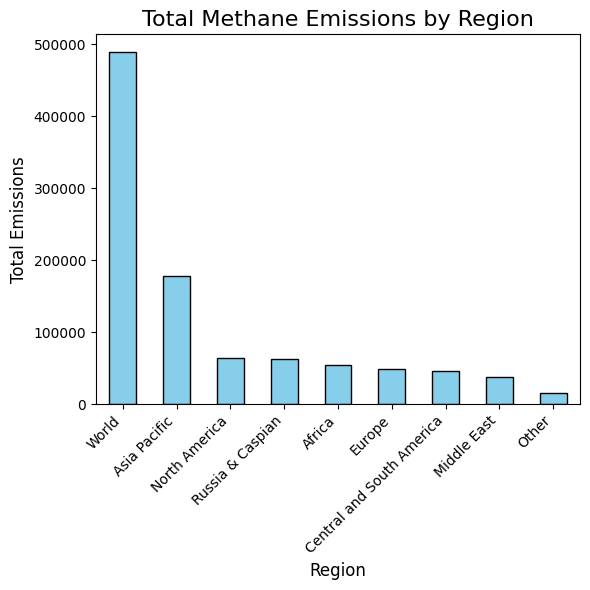

In [7]:
# Visualization 1: Total emissions by region
region_emissions = methane_data.groupby('region')['emissions'].sum().sort_values(ascending=False)
plt.figure(figsize=(6,6))
region_emissions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Methane Emissions by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2) Which is the top 10 countries with the highest methane emissions

In [8]:
#2. Top 10 countries with the highest methane emissions
query="""SELECT country, SUM(emissions) AS total_emissions
FROM project1
GROUP BY country
ORDER BY total_emissions DESC
LIMIT 10;"""
cur.execute(query)

data = cur.fetchall()

data

[('World', 9293894.022155762),
 ('China', 1539919.060131073),
 ('United States', 923492.6686325073),
 ('Russia', 806225.6662731171),
 ('India', 662188.140337944),
 ('Brazil', 412695.9244019985),
 ('Indonesia', 368684.91099739075),
 ('European Union', 360718.2957673073),
 ('Other', 303949.7863308761),
 ('Iran', 247583.02195861936)]

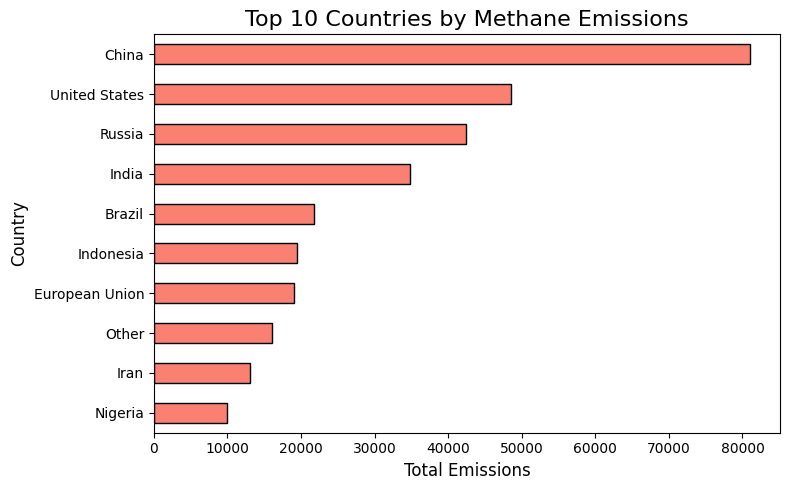

In [9]:
# Visualization 2: Top 10 countries with the highest methane emissions
# Exclude "World" or similar aggregate entries if present
filtered_data = methane_data[methane_data['country'] != 'World']

# Group by country and calculate total emissions
country_emissions = (
    filtered_data.groupby('country')['emissions']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the updated data
plt.figure(figsize=(8,5))
country_emissions.plot(kind='barh', color='salmon', edgecolor='black')
plt.title('Top 10 Countries by Methane Emissions', fontsize=16)
plt.xlabel('Total Emissions', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 3) What is the total emissions by type of activity  

In [10]:
 #3. Total emissions by type of activity
query="""SELECT type, SUM(emissions) AS total_emissions
FROM project1
GROUP BY type
ORDER BY total_emissions DESC;"""
cur.execute(query)

data = cur.fetchall()

data

[('Energy', 10210529.918995708),
 ('Agriculture', 5562418.506619163),
 ('Waste', 2770929.9409713745),
 ('Other', 375566.29083199054)]

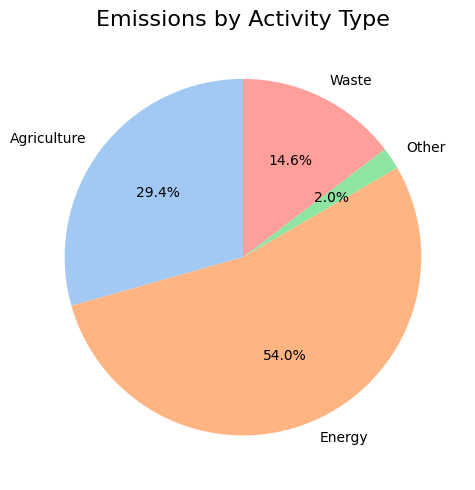

In [11]:
# Visualization 3: Total emissions by type of activity
type_emissions = methane_data.groupby('type')['emissions'].sum()
plt.figure(figsize=(5,5))
type_emissions.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Emissions by Activity Type', fontsize=16)
plt.ylabel('')  # Hide y-axis label for pie chart
plt.tight_layout()
plt.show()

# 4) What is the emissions breakdown by segment for a specfic region (e.g, Africa) 

In [12]:
#4. Emissions breakdown by segment for a specific region (e.g., "Africa")
query="""SELECT segment, SUM(emissions) AS total_emissions
FROM project1
WHERE region = 'Africa'
GROUP BY segment
ORDER BY total_emissions DESC;"""
cur.execute(query)

data = cur.fetchall()

data

[('Total', 777655.0568350675),
 ('Onshore oil', 84908.93836448458),
 ('Bioenergy', 56014.12855668366),
 ('Offshore oil', 42414.15938782133),
 ('Steam coal', 21285.315410614014),
 ('Onshore gas', 20390.074943582527),
 ('Gas pipelines and LNG facilities', 12078.692547310144),
 ('Offshore gas', 9241.481057420373),
 ('Other from oil and gas', 1867.342735051643),
 ('Coking coal', 1677.513786315918),
 ('Satellite-detected large oil and gas emissions', 1368.0),
 ('Other from coal', 845.1960252984427)]

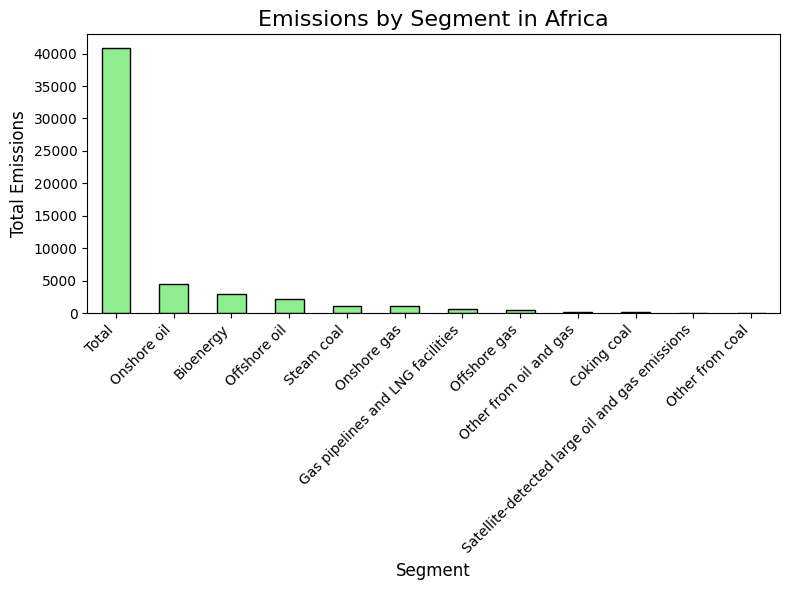

In [13]:
# Visualization 4: Emissions breakdown by segment for a specific region (e.g., "Africa")
africa_segment_emissions = (
    methane_data[methane_data['region'] == 'Africa']
    .groupby('segment')['emissions']
    .sum()
    .sort_values(ascending=False)
)
plt.figure(figsize=(8, 6))
africa_segment_emissions.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Emissions by Segment in Africa', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5) What is the annual methane emissions trend for a specific country (e.g, Algeria)

In [14]:
#5. Annual methane emissions trend for a specific country (e.g., "Algeria")
query="""SELECT baseYear, SUM(emissions) AS total_emissions
FROM project1
WHERE country = 'Algeria'
GROUP BY baseYear
ORDER BY baseYear;"""
cur.execute(query)

data = cur.fetchall()

data

[('2019-2021', 14725.998138904572), ('2022', 101429.3952254192)]

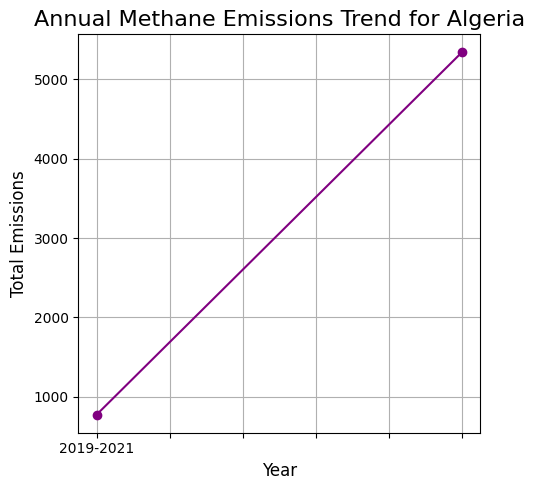

In [15]:
# Visualization 5: Annual methane emissions trend for a specific country (e.g., "Algeria")
algeria_emissions_trend = (
    methane_data[methane_data['country'] == 'Algeria']
    .groupby('baseYear')['emissions']
    .sum()
    .sort_index()
)
plt.figure(figsize=(5,5))
algeria_emissions_trend.plot(kind='line', marker='o', color='purple')
plt.title('Annual Methane Emissions Trend for Algeria', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Give the comparison of "Fugitive" and "vented" emissions across all regions

In [16]:
#6. Comparison of "Fugitive" and "Vented" emissions across all regions
query="""SELECT region, reason, SUM(emissions) AS total_emissions
FROM project1
WHERE reason IN ('Fugitive', 'Vented')
GROUP BY region, reason
ORDER BY region, reason;"""
cur.execute(query)

data = cur.fetchall()

data

[('Africa', 'Fugitive', 23877.979966683546),
 ('Africa', 'Vented', 114603.03532489017),
 ('Asia Pacific', 'Fugitive', 46566.297343314625),
 ('Asia Pacific', 'Vented', 90219.09532767534),
 ('Central and South America', 'Fugitive', 19045.986419260502),
 ('Central and South America', 'Vented', 87799.1320896782),
 ('Europe', 'Fugitive', 24812.993451768532),
 ('Europe', 'Vented', 24790.021180793177),
 ('Middle East', 'Fugitive', 46415.872856244445),
 ('Middle East', 'Vented', 206486.37143713236),
 ('North America', 'Fugitive', 89283.74318113178),
 ('North America', 'Vented', 226345.4244364798),
 ('Other', 'Fugitive', 1714.8740055324743),
 ('Other', 'Vented', 2718.2230548579246),
 ('Russia & Caspian', 'Fugitive', 85136.65500187874),
 ('Russia & Caspian', 'Vented', 241819.79410731792),
 ('World', 'Fugitive', 327568.88885498047),
 ('World', 'Vented', 987746.9187011719)]

<Figure size 1200x600 with 0 Axes>

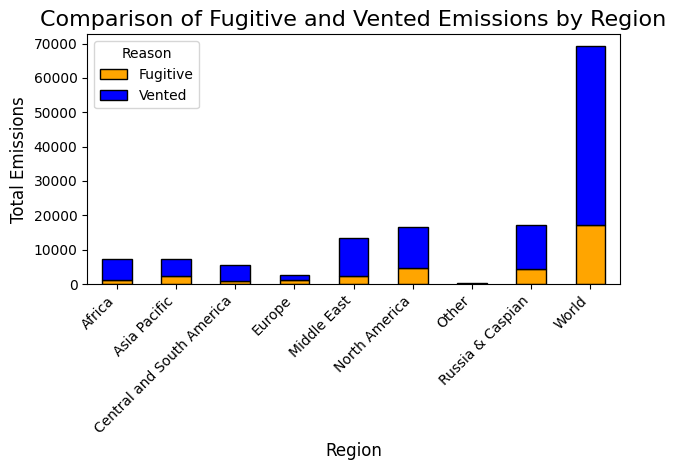

In [17]:
# Visualization 6: Comparison of "Fugitive" and "Vented" emissions across all regions
fugitive_vented_emissions = (
    methane_data[methane_data['reason'].isin(['Fugitive', 'Vented'])]
    .groupby(['region', 'reason'])['emissions']
    .sum()
    .unstack()
)
plt.figure(figsize=(12, 6))
fugitive_vented_emissions.plot(kind='bar', stacked=True, color=['orange', 'blue'], edgecolor='black')
plt.title('Comparison of Fugitive and Vented Emissions by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Reason')
plt.tight_layout()
plt.show()

## "fugitive" describes unintentional leaks or emissions from equipment like pipes, valves, or tanks, while 
## "vented" refers to a deliberate release of gas through a designated vent, often for safety reasons or to control pressure within a system

# 7) What is the total methane emissions for each year

In [18]:
query='''SELECT baseYear AS Year, 
    SUM(emissions) AS Total_Emissions
    FROM project1
    GROUP BY baseYear
    ORDER BY baseYear;'''
cur.execute(query)

data=cur.fetchall()

data

[('2019-2021', 8708914.738422528), ('2022', 10210529.918995708)]

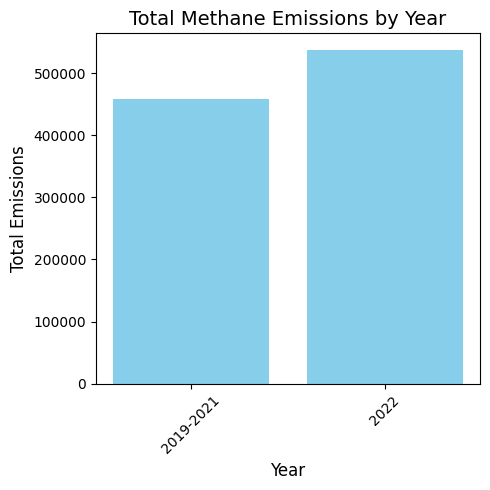

In [19]:
# 7. Total methane emissions for each year
emissions_by_year = methane_data.groupby('baseYear')['emissions'].sum().reset_index()
plt.figure(figsize=(5,5))
plt.bar(emissions_by_year['baseYear'], emissions_by_year['emissions'], color='skyblue')
plt.title('Total Methane Emissions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8) Explain the breakdown of emisions by type for a specific country ( e.g, India)

In [22]:
query="""SELECT type, 
SUM(emissions) AS total_emissions
FROM project1
WHERE country = 'India'
GROUP BY type
ORDER BY type;"""
cur.execute(query)

data=cur.fetchall()

data



[('Agriculture', 348811.833984375),
 ('Energy', 197038.97468852997),
 ('Other', 10853.877563476562),
 ('Waste', 105483.4541015625)]

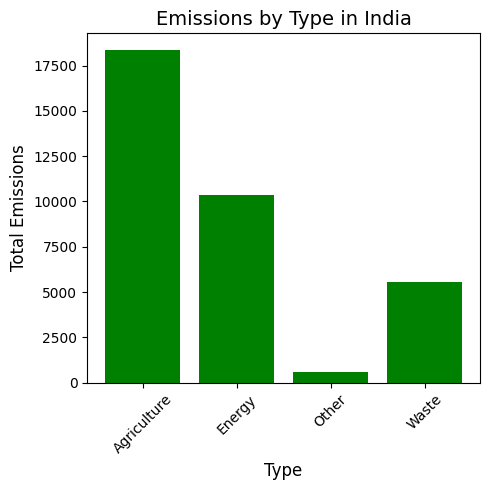

In [23]:
# 8. Breakdown of emissions by type for a specific country (e.g., 'India')
india_emissions_by_type = methane_data[methane_data['country'] == 'India'].groupby('type')['emissions'].sum().reset_index()
plt.figure(figsize=(5,5))
plt.bar(india_emissions_by_type['type'], india_emissions_by_type['emissions'], color='green')
plt.title('Emissions by Type in India', fontsize=14)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9) Explain propotion of 'Fugitive' emissions across all segments globally

In [33]:
query= """SELECT segment,
SUM(emissions) AS total_emissions
FROM project1
WHERE reason = 'Fugitive'
GROUP BY segment;"""
cur.execute(query)

data=cur.fetchall()

data




[('Gas pipelines and LNG facilities', 304860.3908162825),
 ('Onshore gas', 216114.86353427288),
 ('Onshore oil', 72885.04650039086),
 ('Offshore oil', 18499.35892405652),
 ('Offshore gas', 52063.63130579237)]

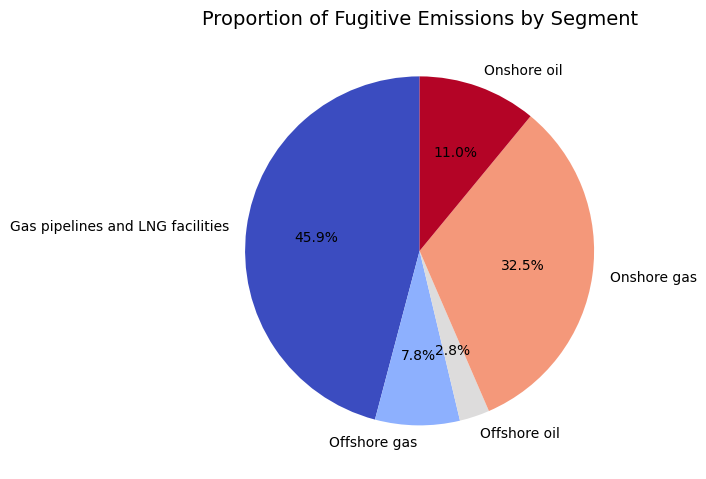

In [24]:
# 9. Proportion of 'Fugitive' emissions across all segments globally
fugitive_emissions = methane_data[methane_data['reason'] == 'Fugitive'].groupby('segment')['emissions'].sum()
fugitive_emissions.plot(kind='pie', autopct='%1.1f%%', figsize=(7,7), startangle=90, colormap='coolwarm')
plt.title('Proportion of Fugitive Emissions by Segment', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

# 10) Explain total emisions grouped by reasons and type

In [34]:
query="""SELECTreason,
type,
SUM(emissions) AS total_emissions
FROMproject1
GROUP BY reason, type
ORDER BY reason, type"""
cur.execute(query)

data=cur.fetchall()

data



[('All', 'Agriculture', 5562418.506619163),
 ('All', 'Energy', 7271521.741905397),
 ('All', 'Other', 375566.29083199054),
 ('All', 'Waste', 2770929.9409713745),
 ('Flared', 'Energy', 292056.8703495388),
 ('Fugitive', 'Energy', 664423.2910807951),
 ('Vented', 'Energy', 1982528.0156599968)]

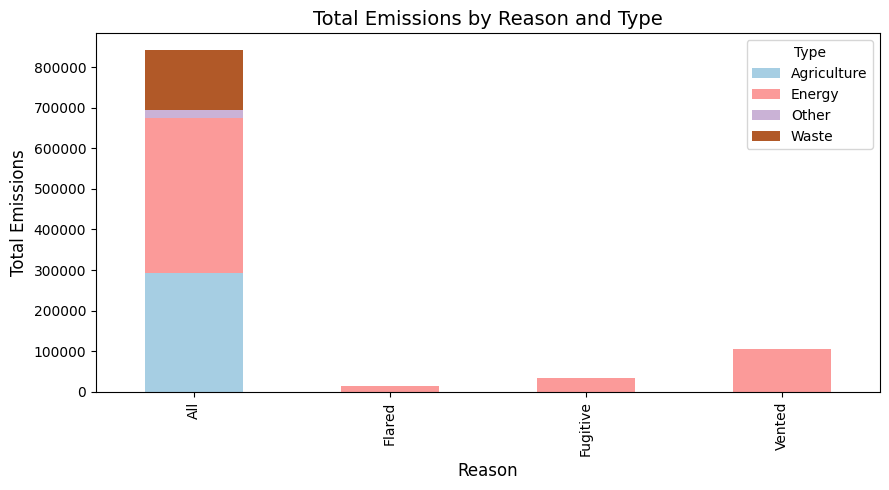

In [25]:
# 10. Total emissions grouped by reasons and type
total_emissions_reason_type = methane_data.groupby(['reason', 'type'])['emissions'].sum().unstack()
total_emissions_reason_type.plot(kind='bar', stacked=True, figsize=(9,5), colormap='Paired')
plt.title('Total Emissions by Reason and Type', fontsize=14)
plt.xlabel('Reason', fontsize=12)
plt.ylabel('Total Emissions', fontsize=12)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

## Conclusion
## This methane data set highlighted key trends and contributors to global methane emissions. Significant emissions stem from regions like Asia and North America and activities such as energy production and agriculture. Fugitive and vented emissions were identified as critical areas of concern. Trends showed regional disparities, emphasizing the need for targeted policies, innovative technologies, and global collaboration to mitigate emissions effectively. This data underscores the importance of data-driven strategies in addressing climate challenges.